## **Importing Libraries**

In [1]:
from tfqml import *

2022-02-22 17:43:30.018244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-22 17:43:30.018266: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-22 17:43:31.100177: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-22 17:43:31.100197: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (toto): /proc/driver/nvidia/version does not exist
2022-02-22 17:43:31.100401: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To en

## **Choose the 8 stocks**

In [2]:
name_stocks = ['AAPL','ABB','ABBV','TOT','WMT','DUK','CHL','HSBC']

# Classical Preprocessing

In [3]:
cp = ClassicalPreprocessing(filename=name_stocks[1])
days = 30
x_train,y_train,x_test,y_test = cp.preprocessing(days=days,flag_pca=True)

Shape of train data: (880, 1)
Shape of test data: (378, 1)


In [4]:
x_train[0]

array([0.12556869, 0.11464958, 0.15741591, 0.23839852, 0.25477705,
       0.25113728, 0.28571426, 0.29572327, 0.37670606, 0.35759769,
       0.33212017, 0.33393982, 0.31028214, 0.34030943, 0.30391253,
       0.31119187, 0.2675159 , 0.27843492, 0.27570516, 0.27843492,
       0.30482245, 0.29117377, 0.29026385, 0.32393082, 0.29845311,
       0.2820745 , 0.24567787, 0.27297532, 0.277525  , 0.27024565])

# Quantum Pre processing

In [5]:
qp = QuantumPreprocessing(x_train,x_test)
x_trainq,x_testq = qp.data2qubits()

Print a quantum circuit of our encoding

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


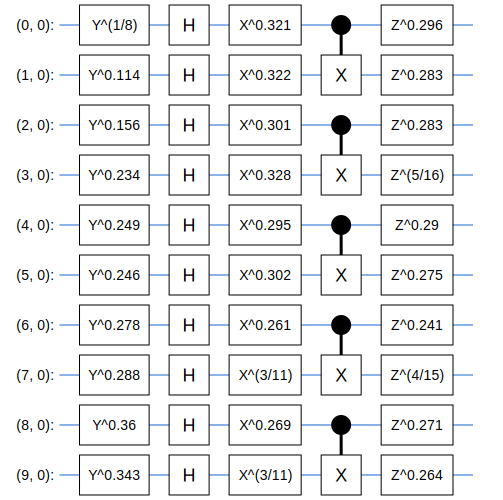

In [6]:
qp.print_circuit(0)

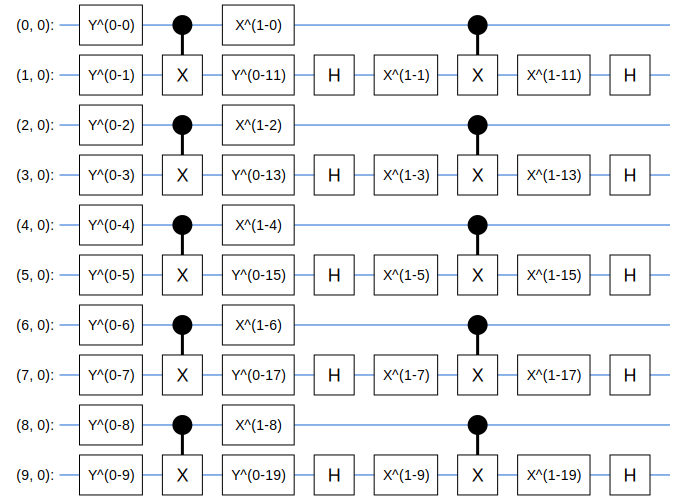

In [7]:
qubits_required = days//3
qm = QuantumModel(qubits_required)
model_circuit, model_readout =qm.quantum_circuit([cirq.Y,cirq.X])
SVGCircuit(model_circuit)

Creating our LSTM hibryd model:

In [8]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate.
    tfq.layers.PQC(model_circuit, model_readout),
    tf.keras.layers.Reshape((1,10)),
    tf.keras.layers.LSTM(units=100, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=100, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=5),
    tf.keras.layers.Dense(units=1),
])


In [9]:
model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 10)                30        
                                                                 
 reshape (Reshape)           (None, 1, 10)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 100)            44400     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 2

In [10]:
qnn_history = model.fit(
      x_trainq, y_train,
      batch_size=32,
      epochs=60)

qnn_results = model.evaluate(x_testq, y_test)


Epoch 1/60
27/27 [==============================] - 6s 113ms/step - loss: 0.2561 - root_mean_squared_error: 0.5061
Epoch 2/60
27/27 [==============================] - 3s 110ms/step - loss: 0.0625 - root_mean_squared_error: 0.2500
Epoch 3/60
27/27 [==============================] - 3s 107ms/step - loss: 0.0220 - root_mean_squared_error: 0.1484
Epoch 4/60
27/27 [==============================] - 3s 111ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300
Epoch 5/60
27/27 [==============================] - 3s 119ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132
Epoch 6/60
27/27 [==============================] - 3s 106ms/step - loss: 0.0094 - root_mean_squared_error: 0.0968
Epoch 7/60
27/27 [==============================] - 3s 114ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871
Epoch 8/60
27/27 [==============================] - 3s 110ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807
Epoch 9/60
27/27 [==============================] - 3s 99ms/step - loss: 0.0064 

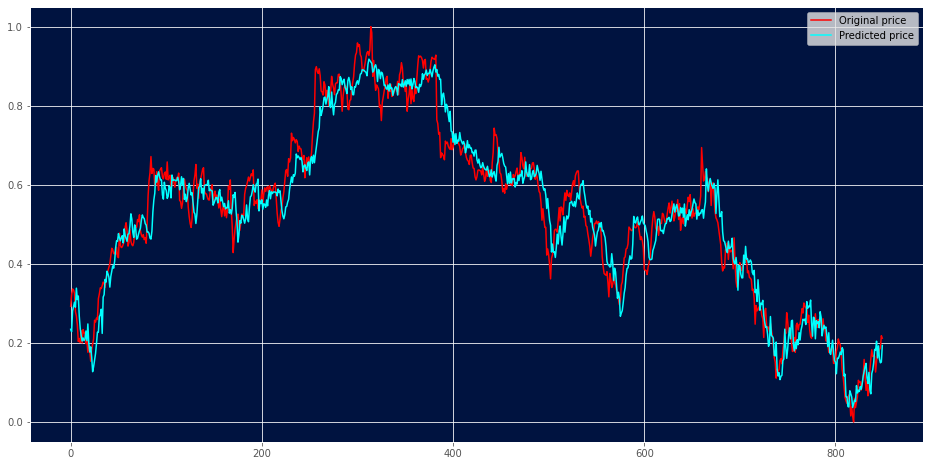

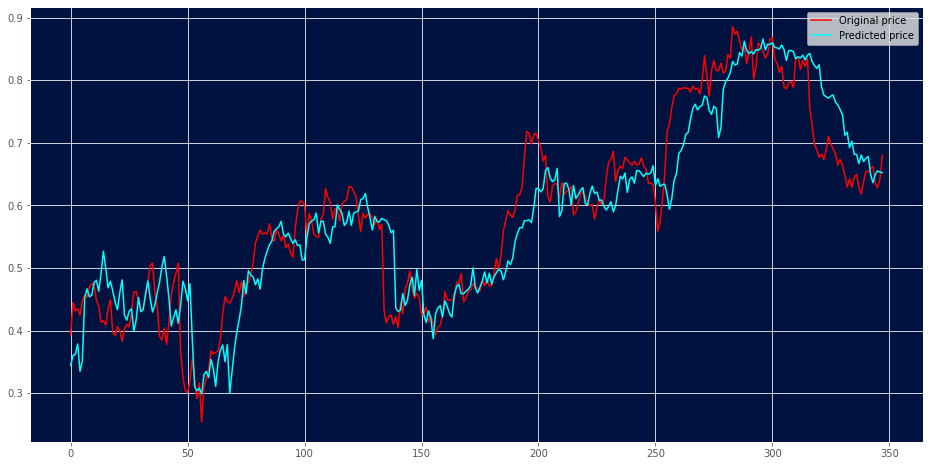

In [11]:
visualization(model,x_trainq,y_train)
visualization(model,x_testq,y_test)

In [12]:
save_data(model,x_trainq,y_train,name_stocks[1]+"_train")
save_data(model,x_testq,y_test,name_stocks[1]+"_test")

MAE 4.11%
MAE 4.32%
